# Long-Short Strategy, Part 1: Preparing Alpha Factors and Features

In this section, we'll start designing, implementing, and evaluating a trading strategy for US equities driven by daily return forecasts produced by gradient boosting models.

As in the previous examples, we'll lay out a framework and build a specific example that you can adapt to run your own experiments. There are numerous aspects that you can vary, from the asset class and investment universe to more granular aspects like the features, holding period, or trading rules. See, for example, the **Alpha Factor Library** in the [Appendix](../24_alpha_factor_library) for numerous additional features.

We'll keep the trading strategy simple and only use a single ML signal; a real-life application will likely use multiple signals from different sources, such as complementary ML models trained on different datasets or with different lookahead or lookback periods. It would also use sophisticated risk management, from simple stop-loss to value-at-risk analysis.

**Six notebooks** cover our workflow sequence:

1. `preparing_the_model_data` (this noteboook): we'll engineer a few simple features from the Quandl Wiki data 
2. [trading_signals_with_lightgbm_and_catboost](05_trading_signals_with_lightgbm_and_catboost.ipynb): we tune hyperparameters for LightGBM and CatBoost to select a model, using 2015/16 as our validation period. 
3. [evaluate_trading_signals](06_evaluate_trading_signals.ipynb): we compare the cross-validation performance using various metrics to select the best model. 
4. [model_interpretation](07_model_interpretation.ipynb): we take a closer look at the drivers behind the best model's predictions.
5. [making_out_of_sample_predictions](08_making_out_of_sample_predictions.ipynb): we generate predictions for our out-of-sample test period 2017.
6. [backtesting_with_zipline](09_backtesting_with_zipline.ipynb): evaluate the historical performance of a long-short strategy based on our predictive signals using Zipline.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import talib
from talib import RSI, BBANDS, MACD, ATR

In [3]:
MONTH = 21
YEAR = 12 * MONTH

In [4]:
START = '2010-01-01'
END = '2017-12-31'

In [5]:
sns.set_style('darkgrid')
idx = pd.IndexSlice

In [6]:
percentiles = [.001, .01, .02, .03, .04, .05]
percentiles += [1-p for p in percentiles[::-1]]

In [7]:
T = [1, 5, 10, 21, 42, 63]

## Loading Quandl Wiki Stock Prices & Meta Data

In [8]:
DATA_STORE = '../data/assets.h5'
ohlcv = ['adj_open', 'adj_close', 'adj_low', 'adj_high', 'adj_volume']
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['finance_datareader/prices']
              .loc[idx[START:END, :], ohlcv] # select OHLCV columns from 2010 until 2017
              .rename(columns=lambda x: x.replace('adj_', '')) # simplify column names
              .swaplevel()
              .sort_index())
    metadata = store['kospi/stocks'].reindex(columns=['시가총액', 'sector'])

In [9]:
prices.volume /= 1e3 # make vol figures a bit smaller
prices.index.names = ['symbol', 'date']
metadata.index.name = 'symbol'

## Remove stocks with insufficient observations

We require at least 7 years of data; we simplify and select using both in- and out-of-sample period; please be aware that it would be more accurate to use only the training period to remove data to avoid lookahead bias.

In [10]:
min_obs = 7 * YEAR
nobs = prices.groupby(level='symbol').size()
keep = nobs[nobs > min_obs].index
prices = prices.loc[idx[keep, :], :]

### Align price and meta data

In [11]:
metadata = metadata[~metadata.index.duplicated() & metadata.sector.notnull()]
metadata.sector = metadata.sector.str.lower().str.replace(' ', '_')

In [12]:
metadata

,시가총액,sector
symbol,,
095570,267823527400,산업용_기계_및_장비_임대업
006840,480886464300,기타_금융업
027410,678632048190,기타_금융업
282330,3258016281000,종합_소매업
138930,2584666500780,기타_금융업
...,...,...
079980,365700000000,화학섬유_제조업
005010,113305322000,1차_철강_제조업
069260,907504653600,기타_화학제품_제조업


In [13]:
shared = (prices.index.get_level_values('symbol').unique()
          .intersection(metadata.index))
metadata = metadata.loc[shared, :]
prices = prices.loc[idx[shared, :], :]

### Limit universe to 1,000 stocks with highest market cap

Again, we simplify and use the entire sample period, not just the training period, to select our universe.

In [14]:
universe = metadata['시가총액'].nlargest(1000).index
prices = prices.loc[idx[universe, :], :]
metadata = metadata.loc[universe]

In [15]:
metadata.sector.value_counts()

기타_금융업            45
자동차_신품_부품_제조업     33
의약품_제조업           33
1차_철강_제조업         27
기초_화학물질_제조업       23
                  ..
무기_및_총포탄_제조업       1
무점포_소매업            1
가정용_기기_제조업         1
기타_사업지원_서비스업       1
소프트웨어_개발_및_공급업     1
Name: sector, Length: 111, dtype: int64

In [16]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1147349 entries, ('005930', Timestamp('2010-01-04 00:00:00')) to ('010580', Timestamp('2017-12-28 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    1147349 non-null  float64
 1   close   1147349 non-null  float64
 2   low     1147349 non-null  float64
 3   high    1147349 non-null  float64
 4   volume  1147349 non-null  float64
dtypes: float64(5)
memory usage: 48.5+ MB


In [17]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 584 entries, 005930 to 010580
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   시가총액    584 non-null    int64 
 1   sector  584 non-null    object
dtypes: int64(1), object(1)
memory usage: 13.7+ KB


### Rank assets by Rolling Average Dollar Volume

#### Compute dollar volume

In [18]:
prices['dollar_vol'] = prices[['close', 'volume']].prod(1).div(1e3)

#### 21-day moving average

In [19]:
# compute dollar volume to determine universe
dollar_vol_ma = (prices
                 .dollar_vol
                 .unstack('symbol')
                 .rolling(window=21, min_periods=1) # 1 trading month
                 .mean())

#### Rank stocks by moving average

In [20]:
prices['dollar_vol_rank'] = (dollar_vol_ma
                            .rank(axis=1, ascending=False)
                            .stack('symbol')
                            .swaplevel())

In [21]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1147349 entries, ('005930', Timestamp('2010-01-04 00:00:00')) to ('010580', Timestamp('2017-12-28 00:00:00'))
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   open             1147349 non-null  float64
 1   close            1147349 non-null  float64
 2   low              1147349 non-null  float64
 3   high             1147349 non-null  float64
 4   volume           1147349 non-null  float64
 5   dollar_vol       1147349 non-null  float64
 6   dollar_vol_rank  1147349 non-null  float64
dtypes: float64(7)
memory usage: 66.0+ MB


## Add some Basic Factors

See [appendix](../24_alpha_factor_library) for details on the below indicators.

### Compute the Relative Strength Index

In [22]:
prices['rsi'] = prices.groupby(level='symbol').close.apply(RSI)

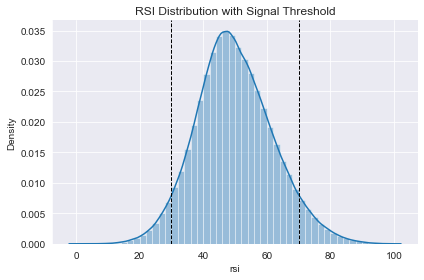

In [23]:
ax = sns.distplot(prices.rsi.dropna())
ax.axvline(30, ls='--', lw=1, c='k')
ax.axvline(70, ls='--', lw=1, c='k')
ax.set_title('RSI Distribution with Signal Threshold')
sns.despine()
plt.tight_layout();

### Compute Bollinger Bands

In [24]:
def compute_bb(close):
    high, mid, low = BBANDS(close, timeperiod=20)
    return pd.DataFrame({'bb_high': high, 'bb_low': low}, index=close.index)

In [25]:
prices = (prices.join(prices
                      .groupby(level='symbol')
                      .close
                      .apply(compute_bb)))

In [26]:
prices['bb_high'] = prices.bb_high.sub(prices.close).div(prices.bb_high).apply(np.log1p)
prices['bb_low'] = prices.close.sub(prices.bb_low).div(prices.close).apply(np.log1p)

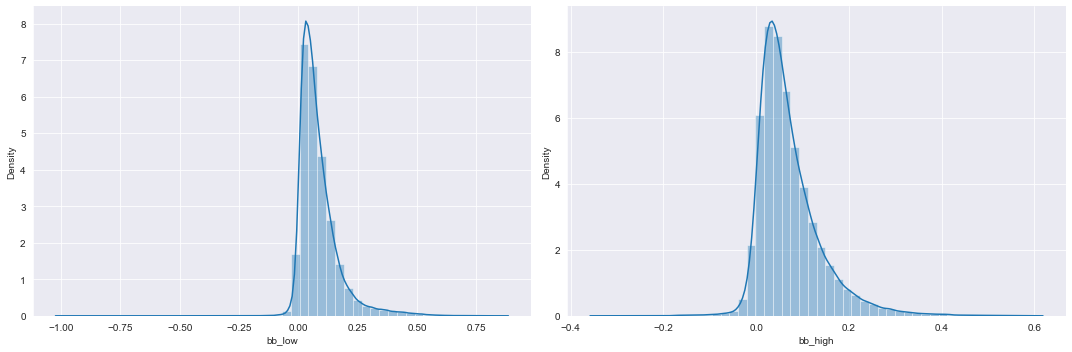

In [27]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_low'].dropna(), ax=axes[0])
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_high'].dropna(), ax=axes[1])
sns.despine()
plt.tight_layout();

### Compute Average True Range

In [28]:
prices['NATR'] = prices.groupby(level='symbol', 
                                group_keys=False).apply(lambda x: 
                                                        talib.NATR(x.high, x.low, x.close))

In [29]:
def compute_atr(stock_data):
    df = ATR(stock_data.high, stock_data.low, 
             stock_data.close, timeperiod=14)
    return df.sub(df.mean()).div(df.std())

In [30]:
prices['ATR'] = (prices.groupby('symbol', group_keys=False)
                 .apply(compute_atr))

### Compute Moving Average Convergence/Divergence

In [31]:
prices['PPO'] = prices.groupby(level='symbol').close.apply(talib.PPO)

In [32]:
def compute_macd(close):
    macd = MACD(close)[0]
    return (macd - np.mean(macd))/np.std(macd)

In [33]:
prices['MACD'] = (prices
                  .groupby('symbol', group_keys=False)
                  .close
                  .apply(compute_macd))

### Combine Price and Meta Data

In [34]:
metadata.sector = pd.factorize(metadata.sector)[0].astype(int)
prices = prices.join(metadata[['sector']])

## Compute Returns

### Historical Returns

In [35]:
by_sym = prices.groupby(level='symbol').close
for t in T:
    prices[f'r{t:02}'] = by_sym.pct_change(t)

## Drop Na Data

In [36]:
prices.dropna(inplace=True)

### Daily historical return deciles

In [37]:
for t in T:
    prices[f'r{t:02}dec'] = (prices[f'r{t:02}']
                             .groupby(level='date')
                             .apply(lambda x: pd.qcut(x, 
                                                      q=10, 
                                                      labels=False, 
                                                      duplicates='drop')))

### Daily sector return deciles

In [38]:
for t in T:
    prices[f'r{t:02}q_sector'] = (prices
                                  .groupby(['date', 'sector'])[f'r{t:02}']
                                  .transform(lambda x: pd.qcut(x, 
                                                               q=5, 
                                                               labels=False, 
                                                               duplicates='drop')))

### Compute Forward Returns

In [39]:
for t in [1, 5, 21]:
    prices[f'r{t:02}_fwd'] = prices.groupby(level='symbol')[f'r{t:02}'].shift(-t)

## Remove outliers

In [40]:
prices[[f'r{t:02}' for t in T]].describe()

,r01,r05,r10,r21,r42,r63
count,1.110557e+06,1.110557e+06,1.110557e+06,1.110557e+06,1.110557e+06,1.110557e+06
mean,5.250009e-04,2.690308e-03,5.343184e-03,1.139162e-02,2.265759e-02,3.302466e-02
std,2.754664e-02,6.433637e-02,9.198499e-02,1.374707e-01,1.962749e-01,2.441924e-01
min,-3.000000e-01,-6.835590e-01,-7.431339e-01,-7.755298e-01,-8.237037e-01,-8.916667e-01
25%,-1.183432e-02,-2.749141e-02,-3.899649e-02,-5.722582e-02,-7.807309e-02,-9.425287e-02
50%,0.000000e+00,-1.226994e-03,-1.693241e-03,-2.079002e-03,0.000000e+00,0.000000e+00
75%,1.072698e-02,2.690583e-02,3.968551e-02,6.174957e-02,9.210526e-02,1.156757e-01
max,3.025641e-01,2.700000e+00,5.004619e+00,7.234589e+00,7.513251e+00,9.958904e+00


We remove daily returns above 100 percent as these are more likely to represent data errors; we are using the 100 percent cutoff here in a somewhat ad-hoc fashion; you would want to apply more careful exploratory and historical analysis to decide which assets are truly not representative of the sample period.

In [41]:
outliers = prices[prices.r01 > 1].index.get_level_values('symbol').unique()

In [42]:
prices = prices.drop(outliers, level='symbol')

## Create time and sector dummy variables

In [43]:
prices['year'] = prices.index.get_level_values('date').year
prices['month'] = prices.index.get_level_values('date').month
prices['weekday'] = prices.index.get_level_values('date').weekday

## Store Model Data

In [44]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1110557 entries, ('005930', Timestamp('2010-04-05 00:00:00')) to ('010580', Timestamp('2017-12-28 00:00:00'))
Data columns (total 39 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   open             1110557 non-null  float64
 1   close            1110557 non-null  float64
 2   low              1110557 non-null  float64
 3   high             1110557 non-null  float64
 4   volume           1110557 non-null  float64
 5   dollar_vol       1110557 non-null  float64
 6   dollar_vol_rank  1110557 non-null  float64
 7   rsi              1110557 non-null  float64
 8   bb_high          1110557 non-null  float64
 9   bb_low           1110557 non-null  float64
 10  NATR             1110557 non-null  float64
 11  ATR              1110557 non-null  float64
 12  PPO              1110557 non-null  float64
 13  MACD             1110557 non-null  float64
 14  sector           1110557 non-null 

In [45]:
prices.drop(['open', 'close', 'low', 'high', 'volume'], axis=1).to_hdf('data.h5', 'model_data')